In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import EngFormatter

import seaborn as sns

rcParams["font.family"] = "Lato"
rcParams["font.size"] = 16
rcParams['text.color'] = '#3F3F3F'
rcParams['axes.labelcolor'] = '#3F3F3F'
rcParams['xtick.color'] = '#3F3F3F'
rcParams['ytick.color'] = '#3F3F3F'


TEAL = ["#b5d1ae", "#80ae9a", "#568b87", "#326b77", "#1b485e", "#122740"]


In [2]:
data = pd.read_csv('merged_all_no_norm.csv', keep_default_na=False, na_values=[''])
data["length"] = data["peptide"].apply(len)
data = data[data["length"] > 2]

In [3]:
data.describe()

,ap,is_assembled,hydrophobic_moment,has_beta_sheet_content,net_charge,length
count,121652.000000,93668.000000,80870.000000,80870.000000,80870.000000,161120.000000
mean,1.811302,0.675823,0.303241,0.001113,-0.022839,6.526763
std,0.295339,0.468069,0.231739,0.033342,1.287768,2.043186
min,0.959986,0.000000,0.000000,0.000000,-6.000000,3.000000
25%,1.650000,0.000000,0.120000,0.000000,-1.000000,5.000000
50%,1.812784,1.000000,0.256000,0.000000,0.000000,6.000000
75%,2.021446,1.000000,0.436000,0.000000,1.000000,8.000000
max,2.897030,1.000000,1.998000,1.000000,6.000000,10.000000


/tmp/ipykernel_3535699/1685020662.py:104: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(d[x]): d[x] = _sort_cat(d[x])
/tmp/ipykernel_3535699/1685020662.py:105: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(d[y]): d[y] = _sort_cat(d[y])
/tmp/ipykernel_3535699/1685020662.py:110: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = ct.applymap(lambda n: _fmt_count(n, heatmap_compact_numbers)) if do_annot else False
/tmp/ipykernel_3535699/1685020662.py:104: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(d[x]): d[x] = _sort_cat(d[x])
/t

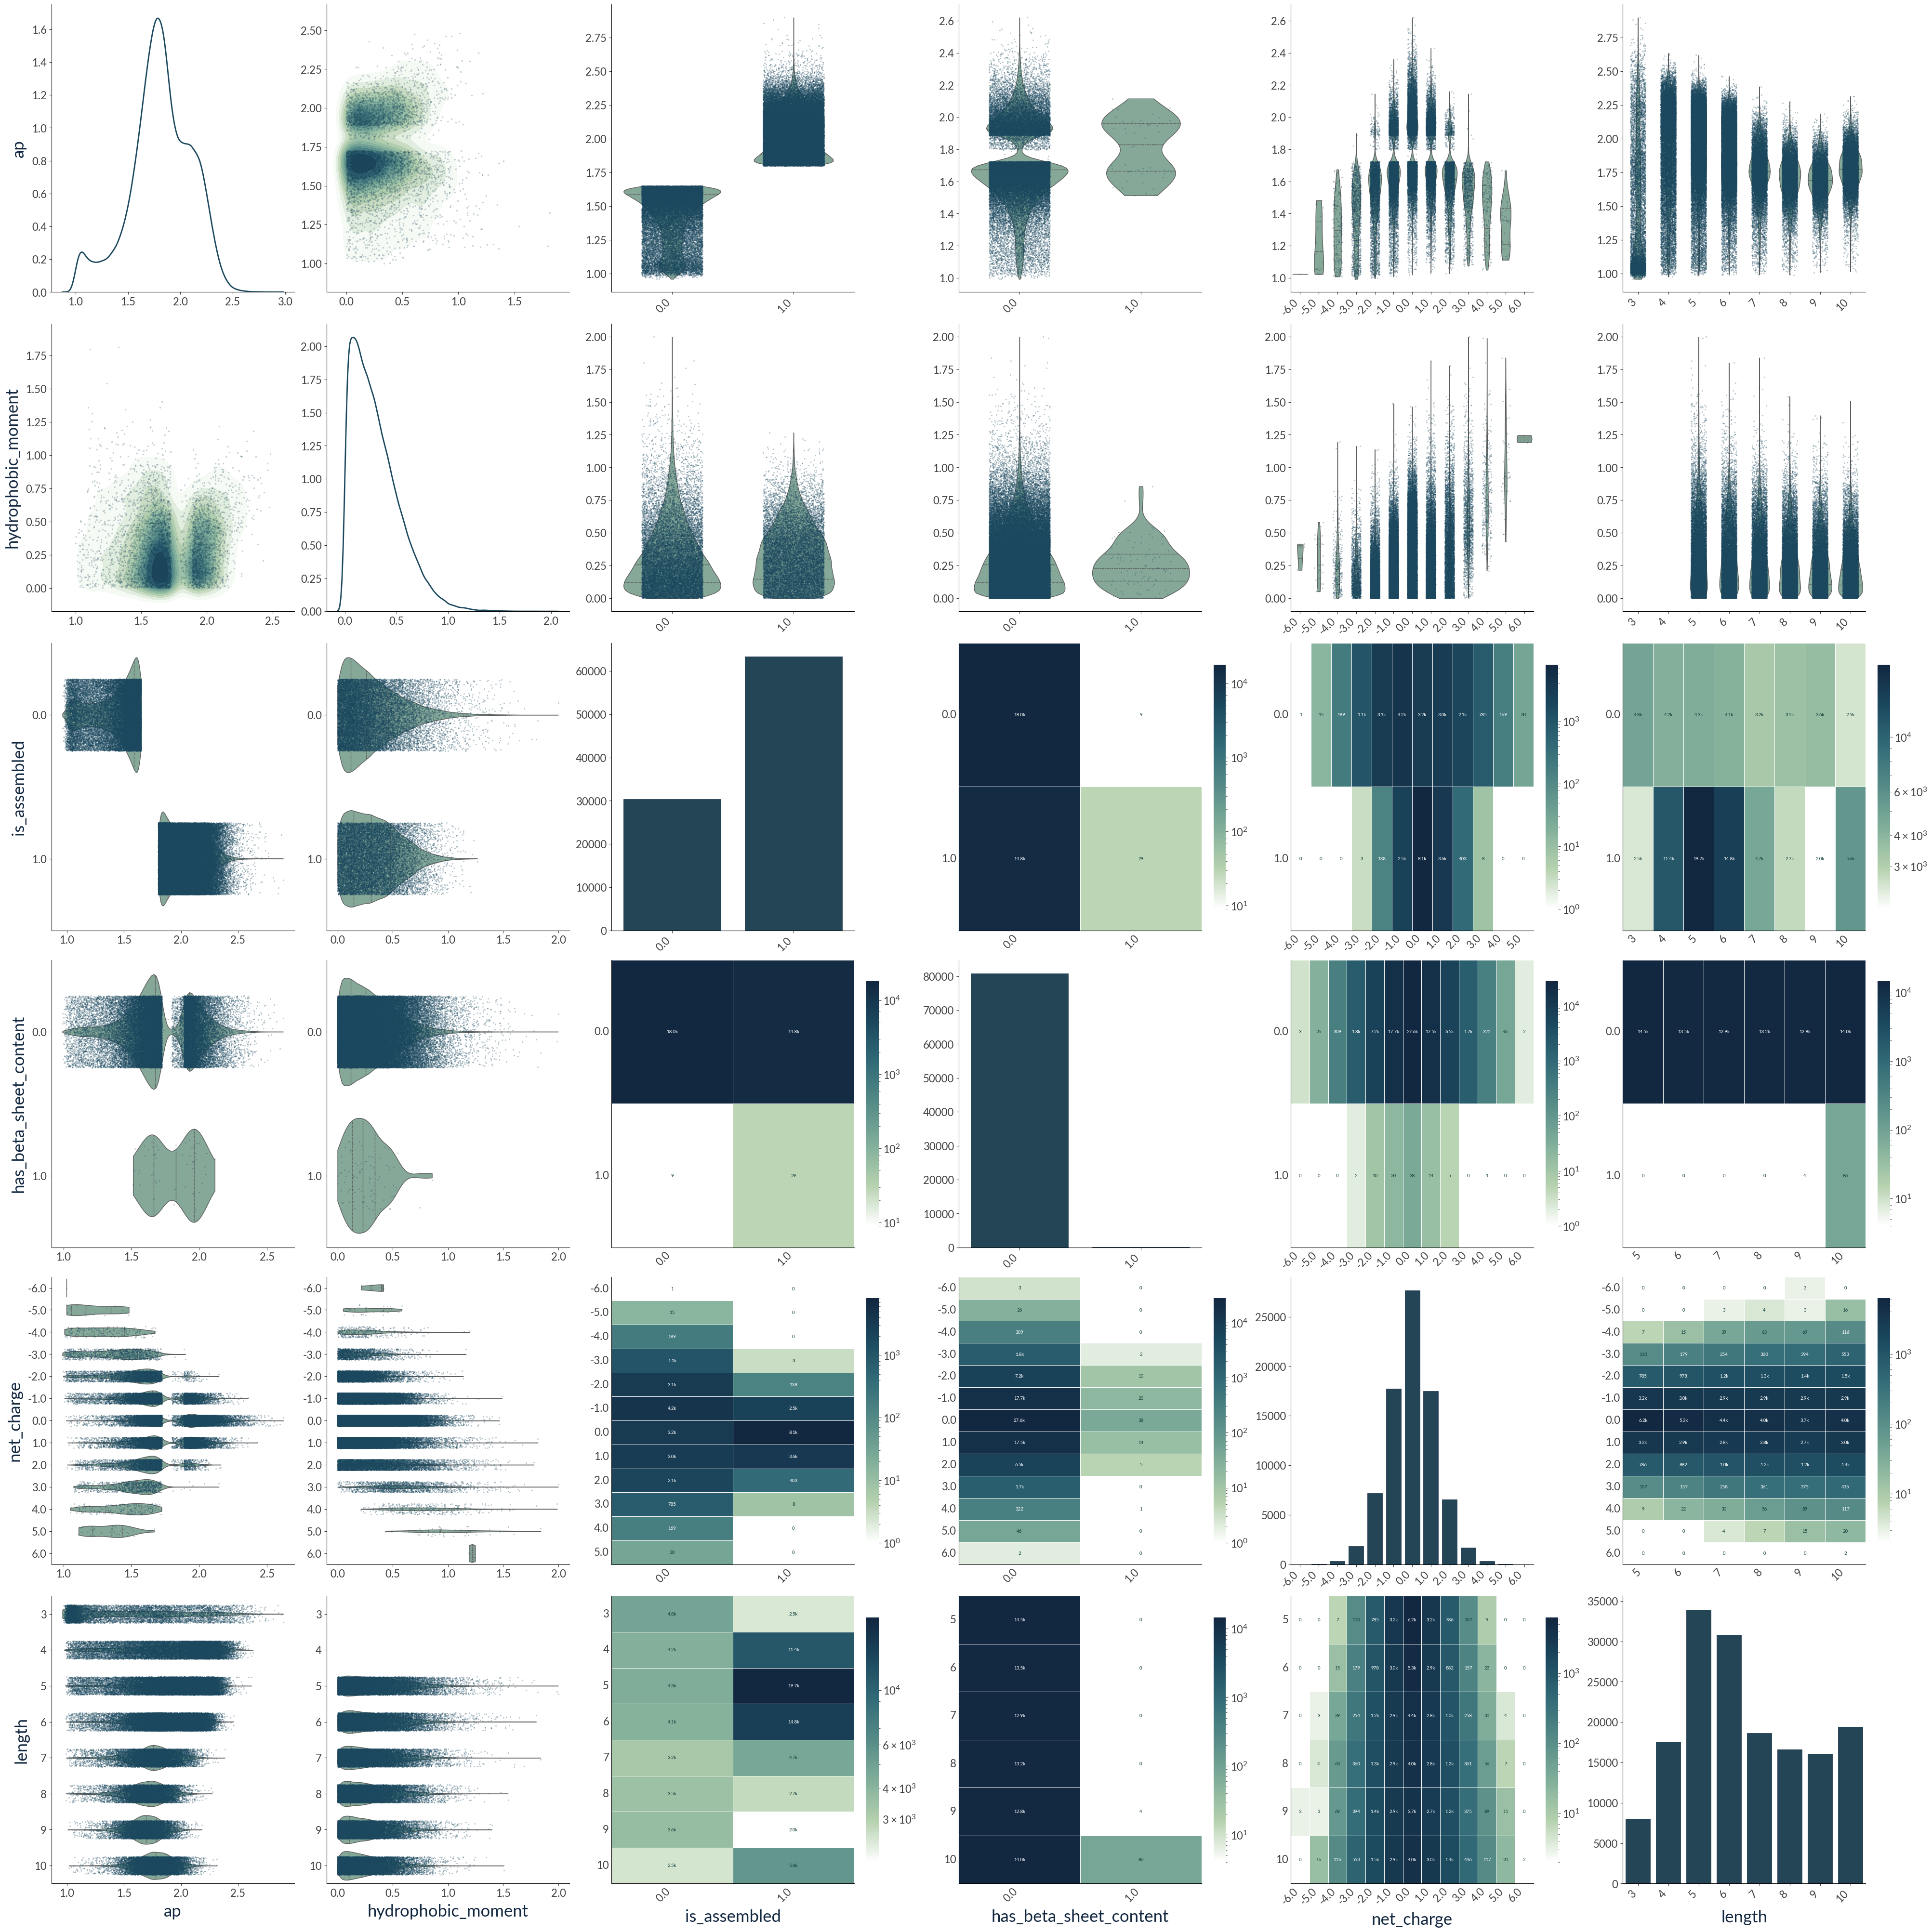

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

# ---- fallback palette if TEAL isn't defined in your session ----
if "TEAL" not in globals():
    TEAL = ["#D0F0EA", "#ACE7DF", "#7ED6C7", "#4AC1AE", "#1FA391", "#0E7B71"]
POINT = TEAL[4]
LINE  = TEAL[2]

def _teal_cmap():
    return LinearSegmentedColormap.from_list(
        "teal_seq", ["#FFFFFF", TEAL[0], TEAL[1], TEAL[2], TEAL[3], TEAL[4], TEAL[5]]
    )

def mixed_pairplot(
    df,
    continuous=("ap", "hydrophobic_moment"),
    binary=("is_assembled", "has_beta_sheet_content"),
    discrete=("net_charge", "length"),
    sample_scatter=5000,
    figsize=(14, 14),
    annotate_heatmap=True,
    heatmap_annot_max_cells=120,
    heatmap_fontsize=7,
    heatmap_compact_numbers=True,
    heatmap_log_counts=False,
    heatmap_cbar_shrink=0.85,
    outer_label_fontsize=16,          # << bigger outer labels
    outer_label_color=TEAL[5],        # dark teal
):
    df = df.copy()
    cont = list(continuous); bin_ = list(binary); disc = list(discrete)
    for c in bin_ + disc:
        if c in df: df[c] = df[c].astype("category")
    cols = cont + bin_ + disc
    for c in cols:
        if c not in df.columns: raise ValueError(f"Column '{c}' not found in df.")

    n = len(cols)
    try:
        fig, axes = plt.subplots(n, n, figsize=figsize, layout="constrained")
    except TypeError:  # older MPL
        fig, axes = plt.subplots(n, n, figsize=figsize, constrained_layout=True)

    kde2d_cmap = _teal_cmap()
    heatmap_cmap = _teal_cmap()

    def _maybe_sample(data, max_n):
        return data.sample(max_n, random_state=0) if len(data) > max_n else data

    def plot_cont_cont(ax, x, y, data):
        d = data[[x, y]].dropna()
        d = _maybe_sample(d, sample_scatter)
        if d.empty: ax.set_visible(False); return
        sns.kdeplot(data=d, x=x, y=y, fill=True, thresh=0.05, levels=12,
                    cmap=kde2d_cmap, alpha=0.95, ax=ax)
        ax.scatter(d[x], d[y], s=6, alpha=0.25, linewidths=0, color=POINT)
        sns.despine(ax=ax)

    def plot_cont_cat(ax, cont_col, cat_col, data, orient=None):
        d = data[[cont_col, cat_col]].dropna()
        if d.empty: ax.set_visible(False); return
        orient = orient or "x"
        if orient == "x":
            sns.violinplot(data=d, x=cat_col, y=cont_col, cut=0, inner="quartile",
                           color=TEAL[1], linewidth=1, ax=ax)
            sns.stripplot(data=d, x=cat_col, y=cont_col, jitter=0.25, alpha=0.35,
                          size=2, dodge=False, color=POINT, ax=ax)
        else:
            sns.violinplot(data=d, y=cat_col, x=cont_col, cut=0, inner="quartile",
                           color=TEAL[1], linewidth=1, ax=ax)
            sns.stripplot(data=d, y=cat_col, x=cont_col, jitter=0.25, alpha=0.35,
                          size=2, dodge=False, color=POINT, ax=ax)
        sns.despine(ax=ax)

    def _fmt_count(n, compact=True):
        if not compact: return str(int(n))
        if n >= 1_000_000: return f"{n/1_000_000:.1f}M"
        if n >= 1_000:     return f"{n/1_000:.1f}k"
        return str(int(n))

    def _thin_ticklabels(ax, labels, axis="x", max_labels=20, rotation=45):
        L = len(labels); step = max(1, L // max_labels) if L > max_labels else 1
        show = [lab if i % step == 0 else "" for i, lab in enumerate(labels)]
        if axis == "x":
            ax.set_xticklabels(show, rotation=rotation, ha="right")
        else:
            ax.set_yticklabels(show, rotation=0)

    def plot_cat_cat(ax, x, y, data):
        d = data[[x, y]].dropna()
        if d.empty: ax.set_visible(False); return

        def _sort_cat(series):
            try:
                vals = pd.to_numeric(series.cat.categories)
                idx = np.argsort(vals)
                return series.cat.reorder_categories(series.cat.categories[idx], ordered=True)
            except Exception:
                return series.cat.reorder_categories(sorted(series.cat.categories), ordered=True)
        if pd.api.types.is_categorical_dtype(d[x]): d[x] = _sort_cat(d[x])
        if pd.api.types.is_categorical_dtype(d[y]): d[y] = _sort_cat(d[y])

        ct = pd.crosstab(d[y], d[x])
        rows, cols_ = ct.shape
        do_annot = annotate_heatmap and (rows * cols_ <= heatmap_annot_max_cells)
        annot_data = ct.applymap(lambda n: _fmt_count(n, heatmap_compact_numbers)) if do_annot else False

        # Draw heatmap
        hm = sns.heatmap(
            ct, ax=ax, cmap=heatmap_cmap,
            cbar=True, cbar_kws={"shrink": heatmap_cbar_shrink},
            annot=annot_data, fmt="s" if do_annot else "",
            annot_kws={"fontsize": heatmap_fontsize},
            linewidths=0.4, linecolor="white",
            norm=LogNorm() if heatmap_log_counts else None,
        )

        # Auto-contrast annotation text
        if do_annot:
            vals = ct.to_numpy()
            if heatmap_log_counts:
                vmin = max(vals[vals > 0].min() if (vals > 0).any() else 1, 1e-9)
                norm = LogNorm(vmin=vmin, vmax=vals.max() if vals.size else 1)
            else:
                norm = plt.Normalize(vmin=vals.min() if vals.size else 0, vmax=vals.max() if vals.size else 1)
            threshold = 0.5
            for txt, v in zip(ax.texts, vals.ravel()):
                txt.set_color("white" if norm(v) >= threshold else "#0E3B36")

        ax.tick_params(length=0)
        _thin_ticklabels(ax, [str(c) for c in ct.columns], axis="x", max_labels=20, rotation=45)
        _thin_ticklabels(ax, [str(r) for r in ct.index],   axis="y", max_labels=20, rotation=0)
        sns.despine(ax=ax, left=False, bottom=False)

    def diag_cont(ax, x, data):
        d = data[[x]].dropna()
        if d.empty: ax.set_visible(False); return
        sns.kdeplot(data=d, x=x, fill=False, color=POINT, linewidth=2, ax=ax)
        sns.despine(ax=ax)

    def diag_cat(ax, x, data):
        d = data[[x]].dropna()
        if d.empty: ax.set_visible(False); return
        order = d[x].value_counts().sort_index().index
        sns.countplot(data=d, x=x, order=order, color=POINT, edgecolor=TEAL[5], linewidth=0.5, ax=ax)
        sns.despine(ax=ax)

    def is_cont(c): return c in cont
    def is_cat(c):  return c in bin_ + disc

    for i, y in enumerate(cols):
        for j, x in enumerate(cols):
            ax = axes[i, j]
            if i == j:
                (diag_cont if is_cont(x) else diag_cat)(ax, x, df)
            else:
                if is_cont(x) and is_cont(y):
                    plot_cont_cont(ax, x, y, df)
                elif is_cont(x) and is_cat(y):
                    plot_cont_cat(ax, cont_col=x, cat_col=y, data=df, orient="y")
                elif is_cat(x) and is_cont(y):
                    plot_cont_cat(ax, cont_col=y, cat_col=x, data=df, orient="x")
                else:
                    plot_cat_cat(ax, x, y, df)

            # keep only outer labels; make them bigger
            if i == n - 1:
                ax.set_xlabel(x, fontsize=outer_label_fontsize, color=outer_label_color, labelpad=8)
            else:
                ax.set_xlabel("")
            if j == 0:
                ax.set_ylabel(y, fontsize=outer_label_fontsize, color=outer_label_color, labelpad=8)
            else:
                ax.set_ylabel("")

            # rotate categorical ticks consistently
            if is_cat(x):
                for tick in ax.get_xticklabels():
                    tick.set_rotation(45); tick.set_ha("right")

    plt.show()
    return fig, axes

# usage
fig, axes = mixed_pairplot(
    data,
    continuous=("ap", "hydrophobic_moment"),
    binary=("is_assembled", "has_beta_sheet_content"),
    discrete=("net_charge", "length"),
    figsize=(40, 40),
    heatmap_log_counts=True,   # optional
    outer_label_fontsize=25,   # tweak as you like
)


In [13]:
#save as high-res PNG
fig.savefig("pairplot_all.png", dpi=300)

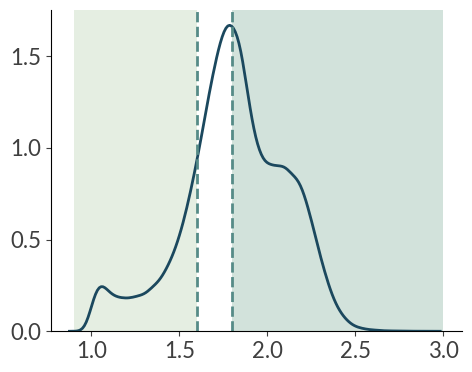

In [5]:
ap = data["ap"].dropna().values
t1, t2 = 1.6, 1.8

fig, ax = plt.subplots(figsize=(5, 4))

# KDE curve
sns.kdeplot(ap, ax=ax, color=TEAL[4], linewidth=2)

# Vertical dashed lines
ax.axvline(t1, color=TEAL[2], linestyle="--", linewidth=2)
ax.axvline(t2, color=TEAL[2], linestyle="--", linewidth=2)

# Shaded regions (lighter teals)
xmin, xmax = np.min(ap), np.max(ap)
ax.axvspan(0.9, t1, facecolor=TEAL[0], alpha=0.35, edgecolor="none")
ax.axvspan(t2, 3, facecolor=TEAL[1], alpha=0.35, edgecolor="none")

# Labels
ax.set_xlabel("")
ax.set_ylabel("")
y_text = ax.get_ylim()[1] * 0.10

sns.despine(ax=ax)
plt.tight_layout()
plt.show()

#save as svg
fig.savefig("ap_kde.svg", format="svg", bbox_inches="tight", dpi=300)

/tmp/ipykernel_3308735/1428509033.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


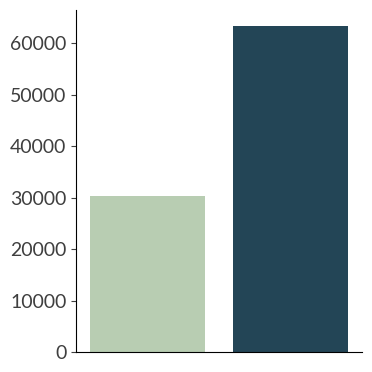

In [16]:
fig, ax = plt.subplots(figsize=(4,4))

# Barplot of counts
sns.countplot(
    x="is_assembled",
    data=data,
    palette=[TEAL[0], TEAL[4]],  # light for 0, dark for 1
    ax=ax
)

# Remove labels & set style
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.tick_params(colors="#3F3F3F", labelsize=14)

for spine in ax.spines.values():
    spine.set_visible(False)

sns.despine(ax=ax)
plt.tight_layout()
plt.show()

# Save as svg
fig.savefig("is_assembled_bar.svg", format="svg", bbox_inches="tight", dpi=300)

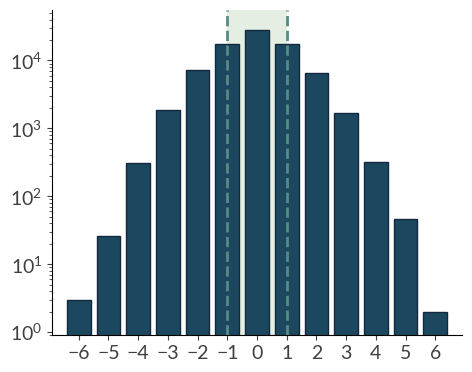

In [7]:
# Prepare discrete counts in [-6, 6]
charges = np.rint(data["net_charge"].dropna().values).astype(int)   # round in case of float types
bins = np.arange(-6, 7)                                            # -6..6 inclusive
counts = {c: 0 for c in bins}
for c in charges:
    if -6 <= c <= 6:
        counts[c] += 1

xs   = np.array(sorted(counts.keys()))
ys   = np.array([counts[k] for k in xs])
mask = ys > 0  # avoid log(0)

fig, ax = plt.subplots(figsize=(5, 4))
l1, l2 = -1, 1

ax.axvspan(l1, l2, facecolor=TEAL[0], alpha=0.35, edgecolor="none", zorder=0)   # 4–7

# Vertical dashed lines
ax.axvline(l1, linestyle="--", linewidth=2, color=TEAL[2], zorder=4)
ax.axvline(l2, linestyle="--", linewidth=2, color=TEAL[2], zorder=4)


# Bars only for positive counts (log-safe)
ax.bar(xs[mask], ys[mask], width=0.8, color=TEAL[4], edgecolor=TEAL[5])

# Axes: discrete x, log y
ax.set_xticks(bins)
ax.set_xlim(-6.9, 6.9)
ax.set_yscale("log")
ax.set_ylim(0.9, max(ys[mask]) * 2)  # leave some space above the highest bar

# Style to match your figures
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=14)
for s in ax.spines.values():
    s.set_visible(False)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

# Save as SVG
fig.savefig("netcharge_hist_log.svg", format="svg", bbox_inches="tight", dpi=300)


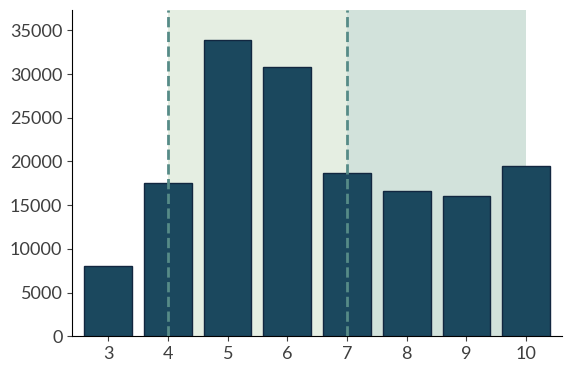

In [8]:
lens = data["length"].dropna().astype(int)
min_x = min(3, lens.min())
max_x = max(10, lens.max())
xs = np.arange(min_x, max_x + 1)
counts = lens.value_counts().reindex(xs, fill_value=0).values

l1, l2 = 4, 7

fig, ax = plt.subplots(figsize=(6, 4))

# Background class overlays (behind bars)
ax.axvspan(l1, l2, facecolor=TEAL[0], alpha=0.35, edgecolor="none", zorder=0)   # 4–7
ax.axvspan(l2, 10, facecolor=TEAL[1], alpha=0.35, edgecolor="none", zorder=0)   # 7–10

# Bars
ax.bar(xs, counts, width=0.8, color=TEAL[4], edgecolor=TEAL[5], zorder=3)

# Vertical dashed lines
ax.axvline(l1, linestyle="--", linewidth=2, color=TEAL[2], zorder=4)
ax.axvline(l2, linestyle="--", linewidth=2, color=TEAL[2], zorder=4)

# Show axes and tick values (no axis titles)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks(xs)
ax.set_xlim(min_x - 0.6, max_x + 0.6)
ax.tick_params(labelsize=13)
ax.set_ylim(0, counts.max() * 1.1)
# Keep left/bottom spines; hide top/right
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

# Save
fig.savefig("length_bar_classes.svg", format="svg", bbox_inches="tight", dpi=300)


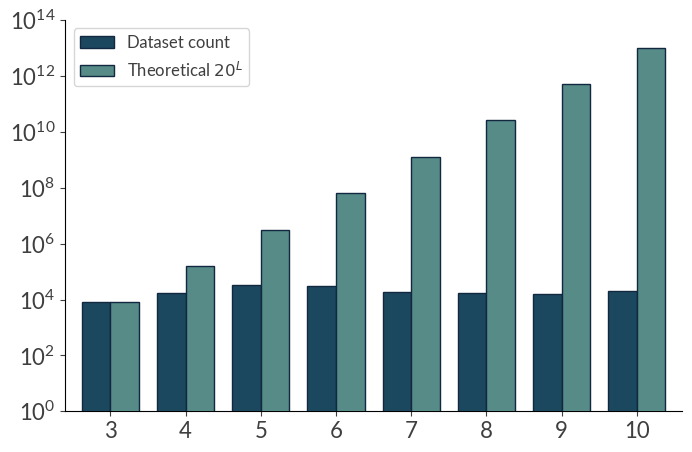

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import LogLocator, LogFormatterMathtext

# --- palette & style ---
try:
    TEAL
except NameError:
    TEAL = ["#b5d1ae", "#80ae9a", "#568b87", "#326b77", "#1b485e", "#122740"]

POINT = TEAL[4]
LINE  = TEAL[2]

# --- data: counts per length ---
lens = data["length"].dropna().astype(int)
min_x = min(3, lens.min())
max_x = max(10, lens.max())
xs = np.arange(min_x, max_x + 1)

# dataset counts (rows). If you want unique sequences per length:
# lens = data.drop_duplicates('sequence')['length'].dropna().astype(int)
counts = lens.value_counts().reindex(xs, fill_value=0).to_numpy()

# theoretical counts: 20^L (canonical AAs, unconstrained)
possible = (20.0 ** xs)

# avoid log(0): drop zero-height bars
counts_plot = counts.astype(float)
counts_plot[counts_plot <= 0] = np.nan

fig, ax = plt.subplots(figsize=(7.2, 4.8))

# optional spans/markers if you already defined l1/l2 earlier
if 'l1' in globals() and 'l2' in globals():
    ax.axvspan(l1, l2, facecolor=TEAL[0], alpha=0.25, edgecolor="none", zorder=0)
    ax.axvspan(l2, max_x, facecolor=TEAL[1], alpha=0.25, edgecolor="none", zorder=0)
    ax.axvline(l1, linestyle="--", linewidth=2, color=TEAL[2], zorder=1)
    ax.axvline(l2, linestyle="--", linewidth=2, color=TEAL[2], zorder=1)

# side-by-side bars
w = 0.38
bars1 = ax.bar(xs - w/2, counts_plot, width=w, color=TEAL[4], edgecolor=TEAL[5],
               zorder=3, label="Dataset count")
bars2 = ax.bar(xs + w/2, possible,     width=w, color=TEAL[2], edgecolor=TEAL[5],
               zorder=3, label=r"Theoretical $20^L$")

# axes
ax.set_xticks(xs)
ax.set_xlim(min_x - 0.6, max_x + 0.6)
ax.set_xlabel(""); ax.set_ylabel("")
sns.despine(ax=ax)

# force base-10 log scale with 10^n tick labels
ax.set_yscale('log', base=10)
ymax_raw = np.nanmax([possible.max(), np.nanmax(counts_plot)])
ymax_pow10 = 10.0 ** np.ceil(np.log10(ymax_raw))
ax.set_ylim(1.0, ymax_pow10)

ax.yaxis.set_major_locator(LogLocator(base=10.0))
ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
# optional: fewer cluttered minor ticks
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[]))

ax.legend(loc='upper left', frameon=True, fontsize=12)

plt.tight_layout()
plt.show()

fig.savefig("length_counts_vs_theoretical.pdf", format="pdf", bbox_inches="tight", dpi=300)

/tmp/ipykernel_2240801/3650423576.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


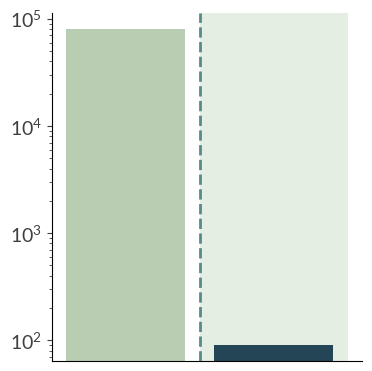

In [9]:
fig, ax = plt.subplots(figsize=(4,4))

# Barplot of counts
sns.countplot(
    x="has_beta_sheet_content",
    data=data,
    palette=[TEAL[0], TEAL[4]],
    ax=ax
)

l1, l2 = 0.5, 1.5
# Background class overlays (behind bars)
ax.axvspan(l1, l2, facecolor=TEAL[0], alpha=0.35, edgecolor="none", zorder=0)   # 4–7

# Vertical dashed lines
ax.axvline(l1, linestyle="--", linewidth=2, color=TEAL[2], zorder=4)

# Remove labels & set style
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.tick_params(colors="#3F3F3F", labelsize=14)
ax.set_yscale("log")

for spine in ax.spines.values():
    spine.set_visible(False)

sns.despine(ax=ax)
plt.tight_layout()
plt.show()

# Save as svg
fig.savefig("has_beta_sheet_content_bar.svg", format="svg", bbox_inches="tight", dpi=300)

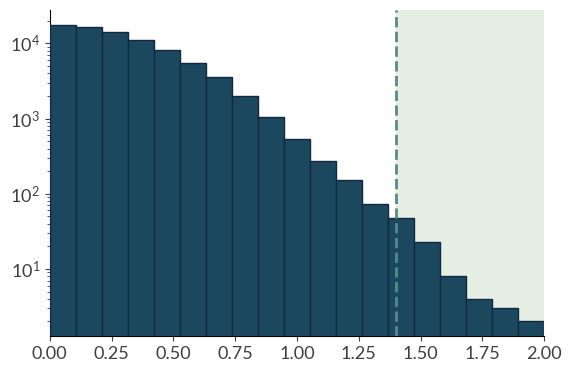

In [10]:
x = data["hydrophobic_moment"].dropna().values

h1, h2 = 1.4, 2.0

xmin = max(0.0, np.floor(x.min()*10)/10)
xmax = max(h2,  np.ceil(x.max()*10)/10)
bins = np.linspace(xmin, xmax, 20)

fig, ax = plt.subplots(figsize=(6, 4))

ax.axvspan(h1, h2, facecolor=TEAL[0], alpha=0.35, edgecolor="none", zorder=0)

ax.hist(x, bins=bins, color=TEAL[4], edgecolor=TEAL[5], log=True, zorder=3)

ax.axvline(h1, linestyle="--", linewidth=2, color=TEAL[2], zorder=4)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xlim(xmin, xmax)
ax.tick_params(labelsize=13)

sns.despine(ax=ax)

plt.tight_layout()
plt.show()

# Save SVG
fig.savefig("hydrophobic_moment_hist.svg", format="svg", bbox_inches="tight", dpi=300)
